In [1]:
%pylab inline
import torch

# Making sure we can find the data loader
import sys
sys.path.append('..')
sys.path.append('../..')
from data import load
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device = ', device)

Populating the interactive namespace from numpy and matplotlib
device =  cpu


In [ ]:
# Let's load the dataset
train_data, train_label = load.get_dogs_and_cats_data(resize=(32,32))
valid_data, valid_label = load.get_dogs_and_cats_data(split='valid', 
                                                     resize=(32,32))
input_size = 32*32*3
to_image = load.to_image_transform()

train_data, train_label = train_data.to(device), train_label.to(device)
valid_data, valid_label = valid_data.to(device), valid_label.to(device)

In [ ]:
class Network2(torch.nn.Module): 
    def __init__(self, *hidden_size): 
        super().__init__()
        layers = [] 
        
        # Add the hidden layers
        n_in = input_size
        for n_out in hidden_size: 
            layers.append(torch.nn.Linear(n_in, n_out))
            layers.append(torch.nn.ReLU())
            n_in = n_out 
            
        # Add the classifier
        layers.append(torch.nn.Linear(n_out, 1))
        self.network = torch.nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.network(x.view(x.size(0), -1)).view(-1)

In [ ]:
%load_ext tensorboard
import tempfile
log_dir = tempfile.mkdtemp()
%tensorboard --logdir {log_dir} --reload_interval 1

In [ ]:
import torch.utils.tensorboard as tb
n_epochs = 100 
batch_size = 128

train_logger = tb.SummaryWriter(log_dir+'/deepnet1/train', flush_secs=1)
valid_logger = tb.SummaryWriter(log_dir+'/deepnet1/valid', flush_secs=1)

# Create the network 
net2 = Network2(100, 50, 50).to(device)

# Create the optimizer
optimizer = torch.optim.SGD(net2.parameters(), 
                            lr=0.01, 
                            momentum=0.9, 
                            weight_decay=1e-4)

# Create the loss
loss = torch.nn.BCEWithLogitsLoss()

# Start training
global_step = 0 
for epoch in range(n_epochs): 
    # Shuffle the data
    permuation = torch.randperm(train_data.size(0))
    
    # Iterate 
    train_accuracy = [] 
    for it in range(0, len(permutation)- batch_size+1, batch_size):
        batch_samples=permuation[it:it+batch_size]
        batch_data, batch_label = train_data[batch_samples], train_label[batch_samples]
        
        # Compute the loss
        o = net2(batch_data)
        loss_val = loss(o, batch_label.float())
        
        train_logger.add_scalar('train/loss', loss_val, global_step=global_step)
        
        # Compute the accuracy
        train_accuracy.extend(((o > 0).long() == batch_label).cpu().detach().numpy())
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        # Increase the global step 
        global_step += 1 
        
    # Evaluate the model 
    valid_pred = net2(valid_data) > 0 
    valid_accuracy = float((valid_pred.long() == valid_label).float().mean())
    
    train_logger.add_scalar('train/accuracy', np.mean(train_accuracy), global_step=global_step)
    valid_logger.add_scalar('valid/accuracy', valid_accuracy, global_step=global_step)

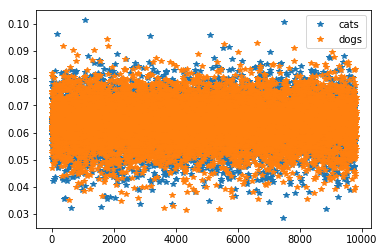

In [8]:
plot(net2(train_data[train_label==0]).view(-1).cpu().detach().numpy(), '*', label='cats')
plot(net2(train_data[train_label==1]).view(-1).cpu().detach().numpy(), '*', label='dogs')
legend()